# Covid-19 Analysis

Looking at the Covid-19 data obtained from 'Our World in Data'.

**Index:**

- [Countries with total cases per capita, top 5](#Highest-total-cases-per-capita,-top-5)
- [Countries with highest death rate per cases, top 5](#Highest-death-rate-per-total-cases,-top-5)
- [Comparison of new cases by countries](#Comparison-of-new-cases-by-countries)
  <br>Edit the name of the countries in filter_countries variable or add new ones to plot<br>
- [Comparison of new cases by countries per capita](#Comparison-of-new-cases-by-countries-per-capita)
 <br>Edit the name of the countries in filter_countries variable or add new ones to plotplot<br>
- [Highest number of total cases and deaths](#Highest-number-of-total-cases-and-deaths)
- [Canadian Provinces and Territories](#Canadian-Provinces-and-Territories)

## Extracting coronavirus and country data

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests

In [92]:
r = requests.get('https://covid.ourworldindata.org/data/ecdc/full_data.csv')

In [93]:
with open('full_data.csv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size = 128):
        fd.write(chunk)

In [94]:
rdata = pd.read_csv('full_data.csv')
rpopulation_data = pd.read_csv('population_data.csv') 

In [95]:
rdata.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths
7013,2020-03-22,Zimbabwe,1,0,2,0
7014,2020-03-23,Zimbabwe,0,0,2,0
7015,2020-03-24,Zimbabwe,0,1,2,1
7016,2020-03-25,Zimbabwe,0,0,2,1
7017,2020-03-26,Zimbabwe,1,0,3,1


In [96]:
rpopulation_data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,NaN


In [97]:
canadian_data = pd.read_csv('canada_covid19.csv')

## Filtering and cleaning data 

In [98]:
print("Data Types", rdata.dtypes)
print("Columns with NaN", rdata.columns[rdata.isna().any()])

Data Types date            object
location        object
new_cases        int64
new_deaths       int64
total_cases      int64
total_deaths     int64
dtype: object
Columns with NaN Index([], dtype='object')


In [99]:
rdata = rdata.fillna(value = 0)
pdata = rdata.astype({'new_cases':'int64', 
                     'new_deaths':'int64', 
                     'total_deaths':'int64'})
pdata.dtypes

date            object
location        object
new_cases        int64
new_deaths       int64
total_cases      int64
total_deaths     int64
dtype: object

In [100]:
rdata['date_fm'] = pd.to_datetime(rdata['date'], infer_datetime_format='%Y-%m-%d')

In [101]:
rdata.dtypes

date                    object
location                object
new_cases                int64
new_deaths               int64
total_cases              int64
total_deaths             int64
date_fm         datetime64[ns]
dtype: object

In [102]:
latest = pdata['date'].max()
latest

'2020-03-26'

In [103]:
world_record = rdata[rdata['location'] == 'World']
data = pdata[pdata['date'] == latest]
data.head()
data = data.drop('date', axis = 1)
data = data.set_index('location')

In [104]:
data = data[data.index != 'World']

In [105]:
max_total_cases = data['total_cases'].max()
print("Max value in total cases", max_total_cases)

Max value in total cases 81968


In [106]:
population = rpopulation_data.filter(['Country Name', '2018'])
population[population['Country Name'] == 'Canada']

,Country Name,2018
33,Canada,37058856.0


In [107]:
population = population.rename(columns = {'Country Name':'location'})
population = population.set_index('location')
population.head(n=1)

,2018
location,
Aruba,105845.0


In [108]:
data[data.index.isin(population.index) == False]

,new_cases,new_deaths,total_cases,total_deaths
location,,,,
Guernsey,7,0,30,0
Jersey,0,0,18,0
Montserrat,0,0,1,0
Palestine,2,0,62,0
Saint Kitts and Nevis,2,0,2,0
Taiwan,19,0,235,2
Vatican,0,0,1,0


In [109]:
data['total_cases_per_capita'] = data['total_cases'].div(data.index.map(population['2018']))
data['total_deaths_per_capita'] = data['total_deaths'].div(data.index.map(population['2018']))
data['deaths_per_total'] = data['total_deaths'].div(data['total_cases'])
data['deaths_per_total'] = data['deaths_per_total'].round(decimals = 4)
data.head()

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Afghanistan,33,0,75,1,2.017627e-06,2.690169e-08,0.0133
Albania,23,0,146,5,5.093540e-05,1.744363e-06,0.0342
Algeria,33,0,264,17,6.251713e-06,4.025724e-07,0.0644
Andorra,24,0,188,0,2.441368e-03,0.000000e+00,0.0000
Angola,0,0,2,0,6.491449e-08,0.000000e+00,0.0000


In [110]:
data.dtypes

new_cases                    int64
new_deaths                   int64
total_cases                  int64
total_deaths                 int64
total_cases_per_capita     float64
total_deaths_per_capita    float64
deaths_per_total           float64
dtype: object

## Plots

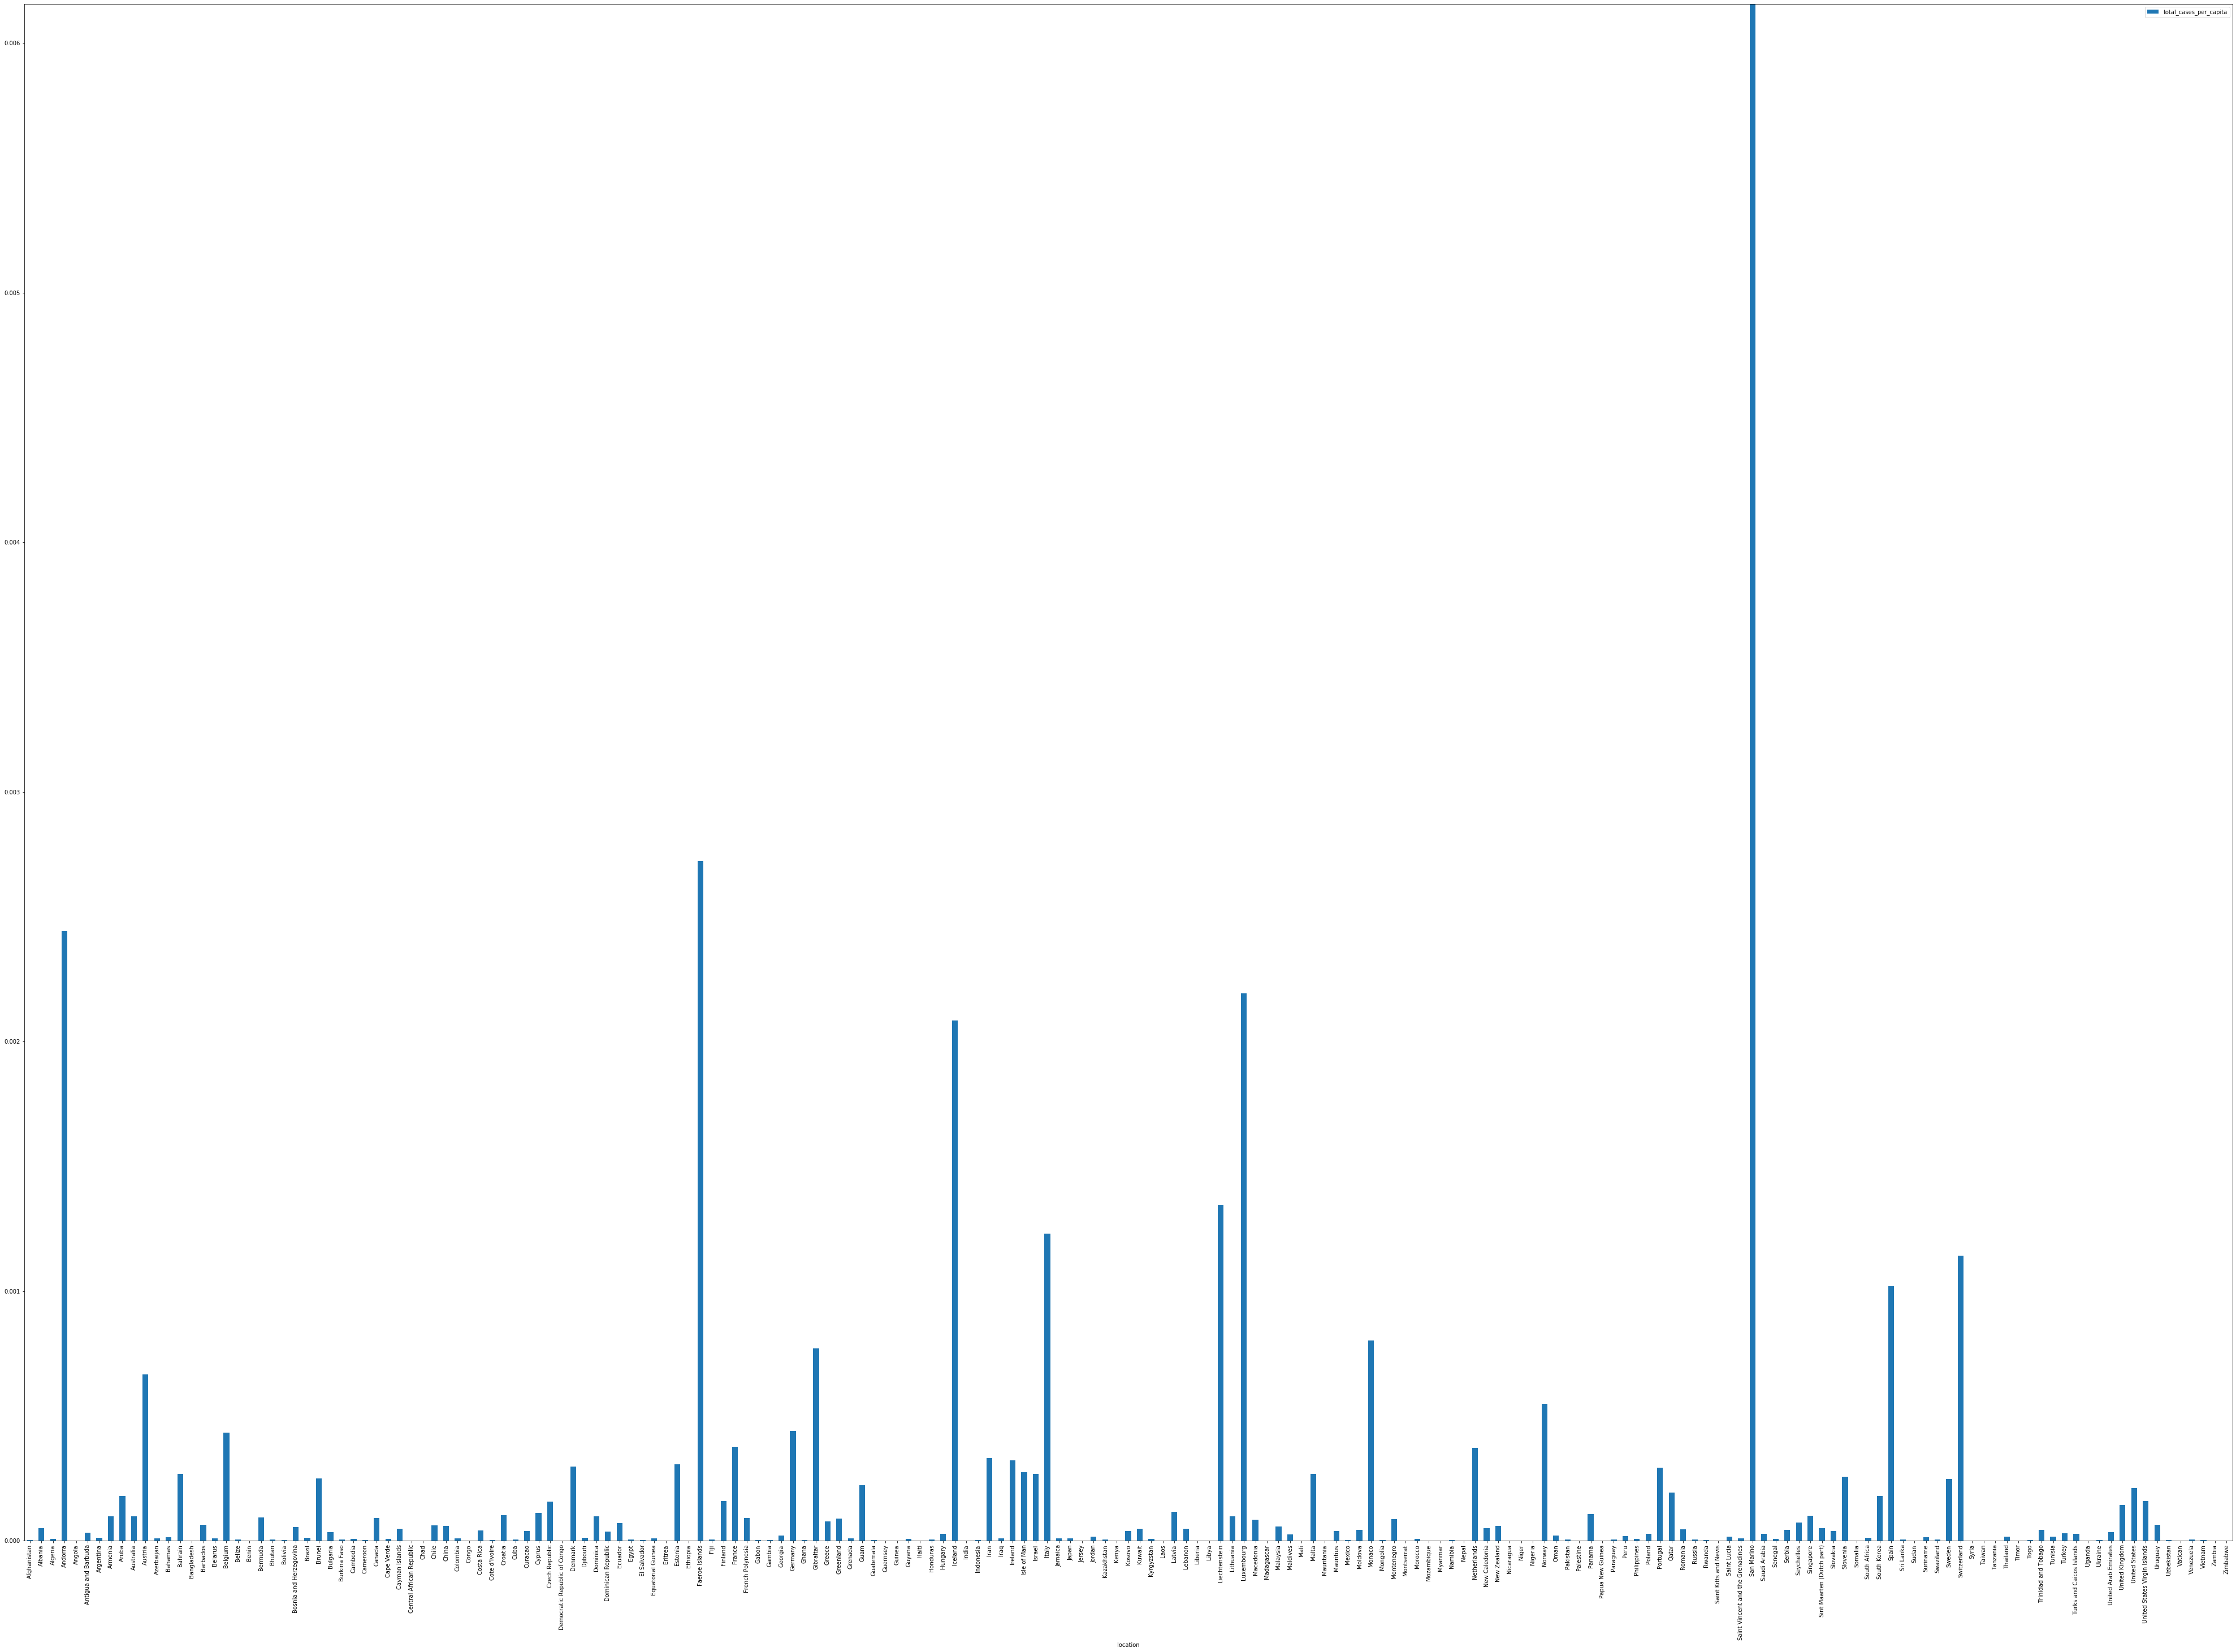

In [111]:
all_rows = data.plot(kind='bar', y = 'total_cases_per_capita', 
                     figsize = (70, 50), ylim = (0, data['total_cases_per_capita'].max())).get_figure()
plt.savefig('all_rows.png')

### World Record

In [112]:
world_record = world_record.drop(columns = ['date'])
world_record = world_record.set_index('date_fm')

In [113]:
world_record[world_record.index == latest]

,location,new_cases,new_deaths,total_cases,total_deaths
date_fm,,,,,
2020-03-26,World,50649,2382,467710,20947


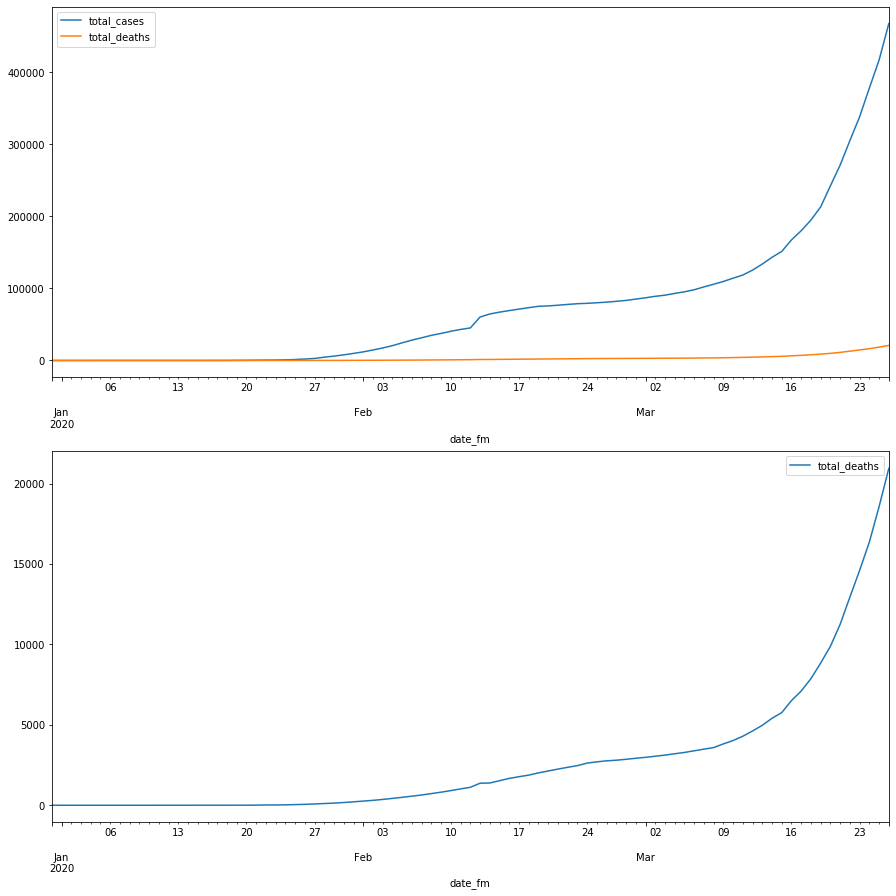

In [114]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,15))

world_record.plot(kind='line', y= ['total_cases', 'total_deaths'], ax = ax1)
world_record.plot(kind='line', y= 'total_deaths', ax = ax2)
plt.savefig('world.png')

### Highest total cases per capita, top 5

In [115]:
largest5 = data.nlargest(5, 'total_cases_per_capita')
largest5

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
San Marino,21,0,208,21,0.006157,0.000622,0.1010
Faeroe Islands,10,0,132,0,0.002722,0.000000,0.0000
Andorra,24,0,188,0,0.002441,0.000000,0.0000
Luxembourg,234,0,1333,8,0.002193,0.000013,0.0060
Iceland,89,0,737,2,0.002084,0.000006,0.0027


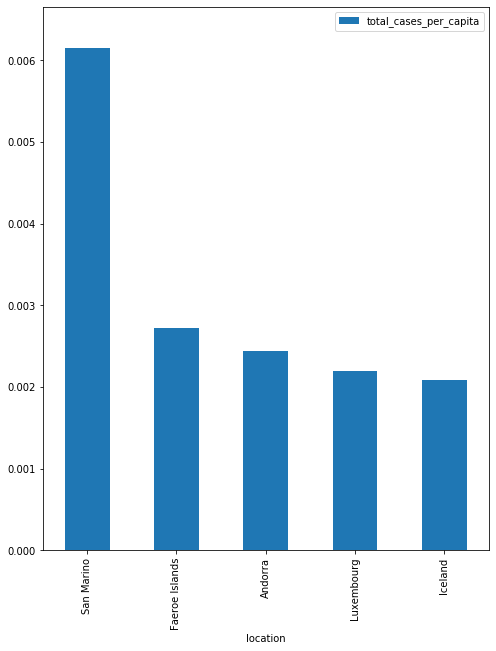

In [116]:
total_cases_pc_fig = largest5.plot(kind='bar', 
                                   y = 'total_cases_per_capita', 
                                   ylim = (0, data['total_cases_per_capita'].max()+ 0.0005),
                                   figsize = (8, 10)).get_figure()
plt.savefig('total_cases_per_capita.png')

In [117]:
largest5 = largest5.merge(population, on = 'location')

In [118]:
filtered_for_table = largest5.drop(columns = ['total_deaths_per_capita', 'deaths_per_total', 'new_deaths', 'total_deaths'])
filtered_for_table = filtered_for_table.reset_index()
filtered_for_table = filtered_for_table.rename(columns = {'2018':'population'})
filtered_for_table

,location,new_cases,total_cases,total_cases_per_capita,population
0,San Marino,21,208,0.006157,33785.0
1,Faeroe Islands,10,132,0.002722,48497.0
2,Andorra,24,188,0.002441,77006.0
3,Luxembourg,234,1333,0.002193,607728.0
4,Iceland,89,737,0.002084,353574.0


### Highest death rate per total cases, top 5

In [119]:
deaths_per_cases = data[data['total_cases'] > 50].nlargest(5, 'deaths_per_total')
deaths_per_cases

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
San Marino,21,0,208,21,0.006157,6.215776e-04,0.1010
Italy,5210,685,74386,7505,0.001231,1.241906e-04,0.1009
Iraq,30,2,346,29,0.000009,7.545481e-07,0.0838
Iran,2206,143,27017,2077,0.000330,2.539111e-05,0.0769
Indonesia,104,3,790,58,0.000003,2.166900e-07,0.0734


In [120]:
deaths_per_cases['deaths_per_total']

location
San Marino    0.1010
Italy         0.1009
Iraq          0.0838
Iran          0.0769
Indonesia     0.0734
Name: deaths_per_total, dtype: float64

In [121]:
deaths_per_cases_pop = deaths_per_cases.merge(population, on = 'location')

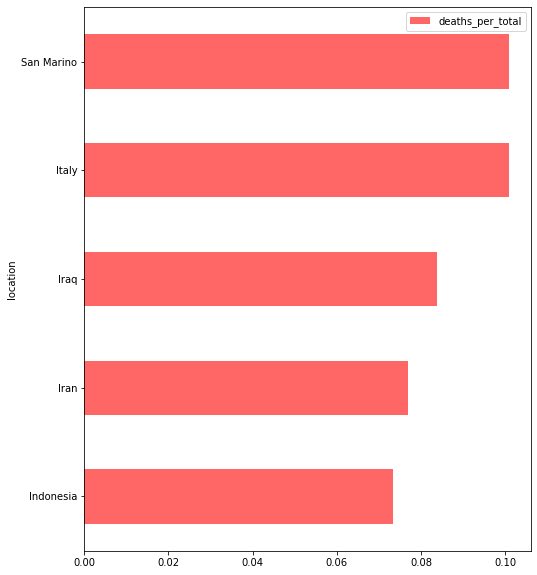

In [122]:
deaths_per_cases_pop.sort_values(by = 'deaths_per_total', ascending = True, inplace = True)
deaths_per_cases_fig = deaths_per_cases_pop.plot.barh(y = 'deaths_per_total', 
                                                      color ='red',
                                                      figsize = (8, 10),
                                                      alpha = 0.6).get_figure()
plt.savefig('deaths_per_cases.png')

In [123]:
filtered_for_table = deaths_per_cases_pop.drop(columns = ['new_cases', 'new_deaths', 'total_cases_per_capita', 'total_deaths_per_capita'])
filtered_for_table = filtered_for_table.reset_index()
filtered_for_table = filtered_for_table.rename(columns = {'2018':'population'})
filtered_for_table

,location,total_cases,total_deaths,deaths_per_total,population
0,Indonesia,790,58,0.0734,267663435.0
1,Iran,27017,2077,0.0769,81800269.0
2,Iraq,346,29,0.0838,38433600.0
3,Italy,74386,7505,0.1009,60431283.0
4,San Marino,208,21,0.1010,33785.0


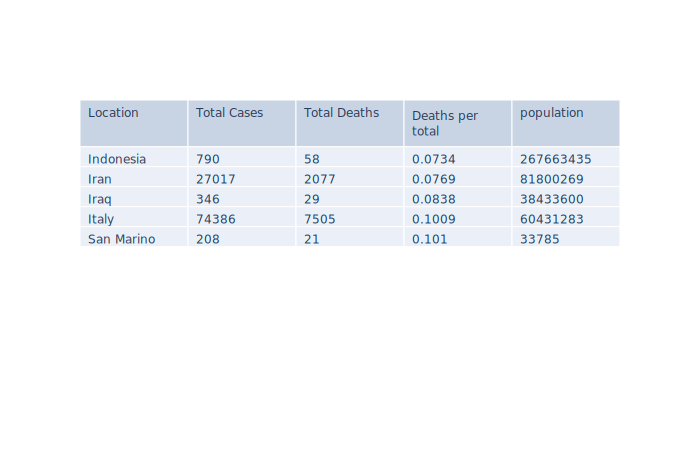

In [124]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Location', 
                        'Total Cases', 
                        'Total Deaths',
                        'Deaths per total', 
                        'population'],
                align='left'),
    cells=dict(values=[filtered_for_table['location'], 
                       filtered_for_table['total_cases'], 
                       filtered_for_table['total_deaths'], 
                       filtered_for_table['deaths_per_total'],
                       filtered_for_table['population']
                      ],
               align='left'))
])

fig.show(renderer="svg")

### Comparison of new cases by countries

In [125]:
filter_countries = ['Canada','United States', 'Pakistan']

In [126]:
data[data.index.isin(filter_countries)]

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Canada,1426,8,3385,35,0.000091,9.444436e-07,0.0103
Pakistan,66,1,1057,8,0.000005,3.769761e-08,0.0076
United States,13963,249,69194,1050,0.000211,3.209366e-06,0.0152


In [127]:
earliest = '2020-03-01'
country_subset = rdata[rdata['location'].isin(filter_countries) & rdata['date_fm'].between(earliest, latest)]

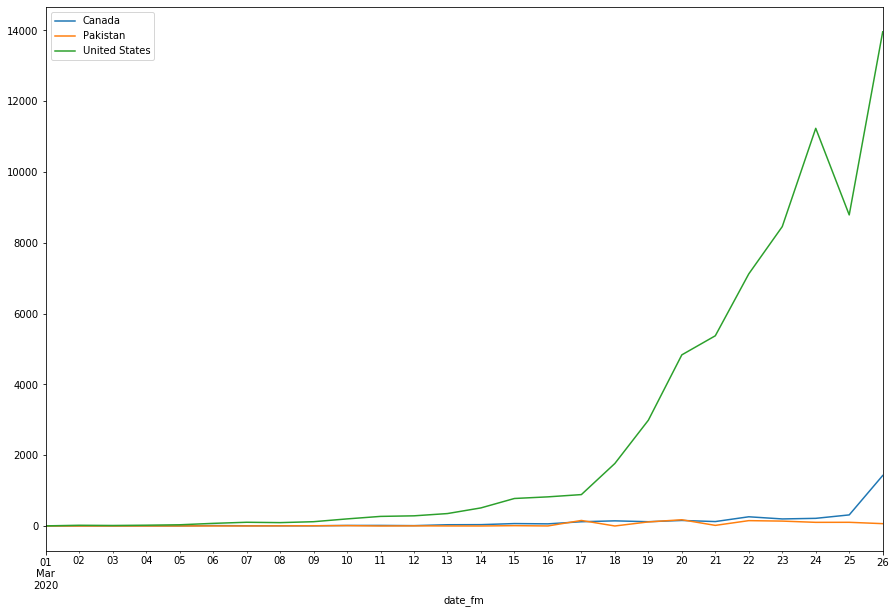

<Figure size 432x288 with 0 Axes>

In [128]:
_, ax = plt.subplots(figsize = (15, 10))

for name, group in country_subset.groupby('location'):
    group.set_index('date_fm').plot(kind ='line', y = 'new_cases', ax = ax, label = name)

plt.show()
plt.savefig('select_countries_new_cases.png')

### Comparison of new cases by countries per capita

In [129]:
percapita = pd.DataFrame(country_subset['location'])
percapita['date_fm'] = country_subset['date_fm']
percapita['new_cases_per_capita'] =  country_subset['new_cases'].div(country_subset['location'].map(population['2018']))

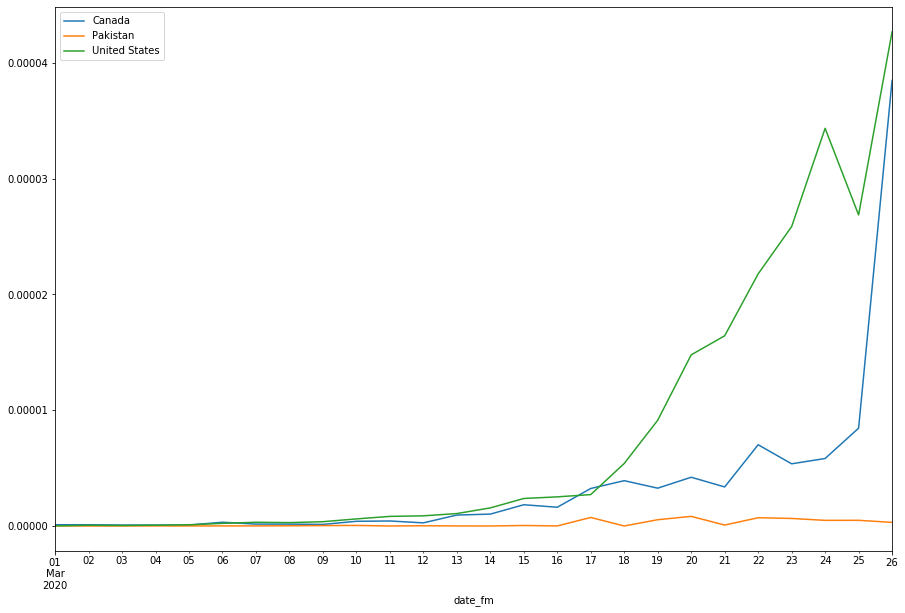

<Figure size 432x288 with 0 Axes>

In [130]:
_, ax = plt.subplots(figsize = (15, 10))

for name, group in percapita.groupby('location'):
    group.set_index('date_fm').plot(kind ='line', y = 'new_cases_per_capita', ax = ax, label = name)

plt.show()
plt.savefig('select_countries_new_cases_per_capita.png')

In [131]:
new_cases_selected_country = country_subset[country_subset['location'] == 'United States'].drop(columns = ['date_fm'])
new_cases_selected_country.tail(n = 10)

,date,location,new_cases,new_deaths,total_cases,total_deaths
6774,2020-03-17,United States,887,16,4661,85
6775,2020-03-18,United States,1766,23,6427,108
6776,2020-03-19,United States,2988,42,9415,150
6777,2020-03-20,United States,4835,0,14250,150
6778,2020-03-21,United States,5374,110,19624,260
6779,2020-03-22,United States,7123,80,26747,340
6780,2020-03-23,United States,8459,131,35206,471
6781,2020-03-24,United States,11236,119,46442,590
6782,2020-03-25,United States,8789,211,55231,801
6783,2020-03-26,United States,13963,249,69194,1050


### Highest number of total cases and deaths

In [132]:
highest_total_cases = data.nlargest(5, 'total_cases')
highest_deaths = data.nlargest(5, 'total_deaths')

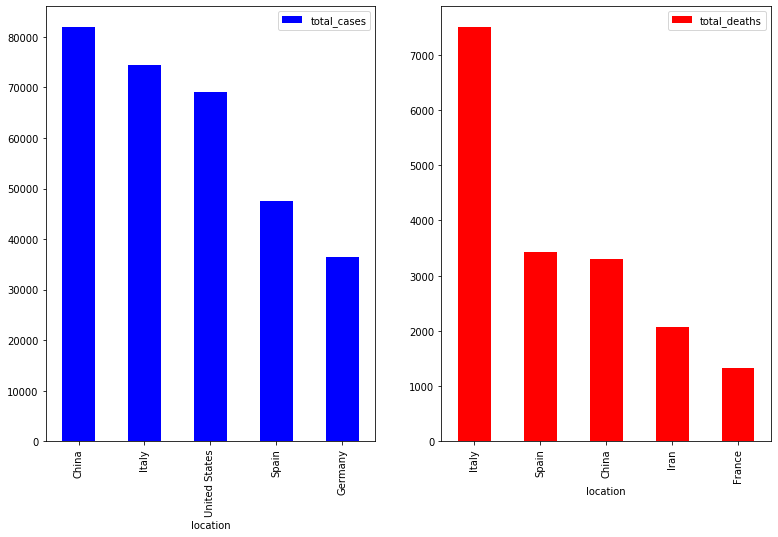

<Figure size 432x288 with 0 Axes>

In [133]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
highest_total_cases.plot(kind = 'bar', y = 'total_cases', color = ['blue'], ax = ax1)
highest_deaths.plot(kind = 'bar', y = 'total_deaths', color = ['red'], ax = ax2)
plt.show()
plt.savefig('highest_total_cases_deaths.png')

In [134]:
highest_total_cases

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
China,121,6,81968,3293,0.000059,0.000002,0.0402
Italy,5210,685,74386,7505,0.001231,0.000124,0.1009
United States,13963,249,69194,1050,0.000211,0.000003,0.0152
Spain,7937,738,47610,3434,0.001019,0.000073,0.0721
Germany,4954,49,36508,198,0.000440,0.000002,0.0054


In [135]:
highest_deaths

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Italy,5210,685,74386,7505,0.001231,0.000124,0.1009
Spain,7937,738,47610,3434,0.001019,0.000073,0.0721
China,121,6,81968,3293,0.000059,0.000002,0.0402
Iran,2206,143,27017,2077,0.000330,0.000025,0.0769
France,2931,231,25233,1331,0.000377,0.000020,0.0527


### Canadian Provinces and Territories

In [136]:
canadian_data = canadian_data.rename(columns = {'Number of confirmed cases': 'Confirmed Cases', 
                                                'Number of probable cases':'Probable Cases',
                                                'Number of deaths': 'Deaths',
                                                'Province, territory or other':'Location'})

In [137]:
canadian_data['Deaths per Confirmed Cases'] = (canadian_data['Deaths'].div(canadian_data['Confirmed Cases']))

In [138]:
canadian_data_total = canadian_data[canadian_data['Location'] == 'Total']
canadian_data = canadian_data[canadian_data['Location'] != 'Total']
canadian_data_total

,Location,Confirmed Cases,Probable Cases,Deaths,Deaths per Confirmed Cases
14,Total,3555,24,35,0.009845


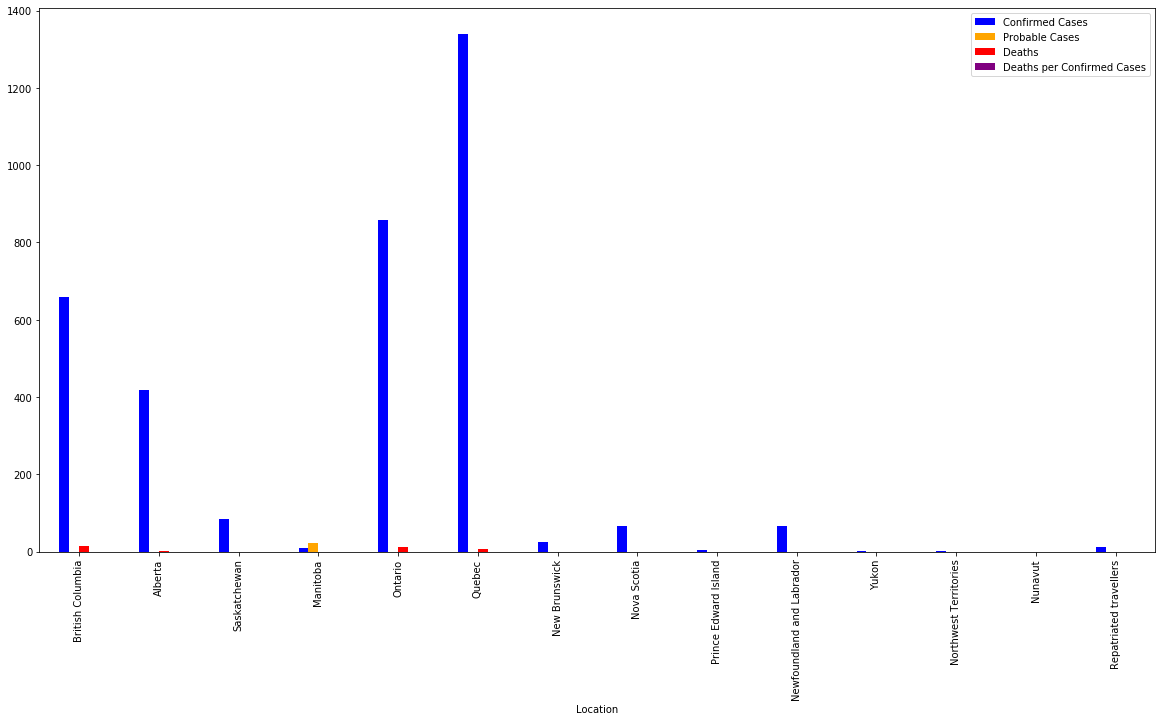

In [139]:
canadian_data.plot(kind = 'bar', x = 'Location', color = ['blue', 'orange', 'red', 'purple'], figsize = (20,10))
plt.savefig('canadian_provinces.png')

In [140]:
canadian_data.nlargest(13, 'Confirmed Cases')

,Location,Confirmed Cases,Probable Cases,Deaths,Deaths per Confirmed Cases
5,Quebec,1339,0,6,0.004481
4,Ontario,858,0,13,0.015152
0,British Columbia,659,0,14,0.021244
1,Alberta,419,0,2,0.004773
2,Saskatchewan,86,0,0,0.000000
7,Nova Scotia,68,0,0,0.000000
9,Newfoundland and Labrador,67,0,0,0.000000
6,New Brunswick,26,0,0,0.000000
13,Repatriated travellers,13,0,0,0.000000
3,Manitoba,11,24,0,0.000000


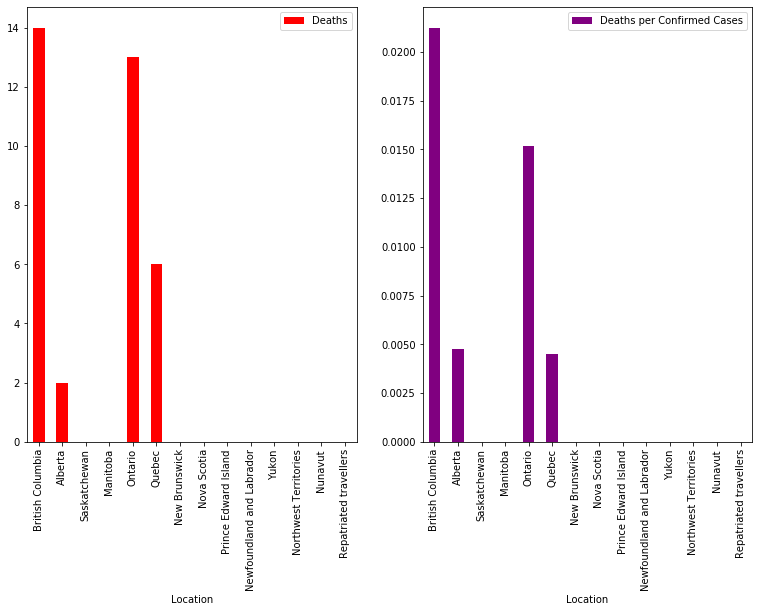

In [141]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
canadian_data.plot(kind = 'bar', x = 'Location', y = 'Deaths', color = ['red'], ax = ax1)
canadian_data.plot(kind = 'bar', x = 'Location', y = 'Deaths per Confirmed Cases', color = ['purple'], ax = ax2)
plt.savefig('canadian_provinces_deaths_per_total.png')

## Resources
1. Data obtained from: https://ourworldindata.org/coronavirus-source-data
2. Population data from: https://data.worldbank.org/indicator/SP.POP.TOTL
3. Canadian data: https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html